# 每月期望值統計資料

In [1]:
import pandas as pd
import numpy as np

dates = ['2017-10','2017-11','2017-12','2018-1','2018-2','2018-3']

df = pd.read_excel('files/data.xlsx', sheetname="data")

df['Date'] = df['成交時間'].dt.year.astype(str)+'-'+df['成交時間'].dt.month.astype(str)
df['Lot'] = df['口數']
df['Balance'] = df['平倉損益']

df = df[['Date','Lot','Balance']]

df

datas = []
for date in dates:
    df1 = df[df['Date']==date]
    if not df1.empty:
        obj = {}
        obj['年月份'] = date
        obj['虧損口數'] = df1[df1['Balance']<0]['Lot'].sum()
        obj['獲利口數'] = df1[df1['Balance']>=0]['Lot'].sum()
        obj['總口數'] = df1['Lot'].sum()
        obj['虧損金額'] = df1[df1['Balance']<0]['Balance'].sum()
        obj['獲利金額'] = df1[df1['Balance']>=0]['Balance'].sum()
        obj['淨利'] = df1['Balance'].sum()
        obj['期望值(E)'] = round((obj['淨利'] / obj['總口數']))
        obj['最大虧損金額'] = df1['Balance'].min()
        obj['最大獲利金額'] = df1['Balance'].max()
        datas.append(obj)
    
df = pd.DataFrame(datas).sort_index(ascending=False)

df[['年月份','虧損口數','獲利口數','總口數','虧損金額','獲利金額','淨利','期望值(E)','最大虧損金額','最大獲利金額']]


,年月份,虧損口數,獲利口數,總口數,虧損金額,獲利金額,淨利,期望值(E),最大虧損金額,最大獲利金額
1,2017-11,7,3,10,-8674,7104,-1570,-157.0,-3132,5968
0,2017-10,6,9,15,-8090,17965,9875,658.0,-2032,14069


# 每月交易統計紀錄

In [2]:
import pandas as pd
import numpy as np

dates = ['2017-10','2017-11','2017-12','2018-1','2018-2','2018-3']


df = pd.read_excel('files/data.xlsx', sheetname="data")

df['Date'] = df['成交時間'].dt.year.astype(str)+'-'+df['成交時間'].dt.month.astype(str)
df['Lot'] = df['口數']
df['Balance'] = df['平倉損益']

df = df[['Date','Lot','Balance']]


datas = []
for date in dates:
    df1 = df[df['Date']==date]
    if not df1.empty:
        obj = {}
        obj['年月份'] = date
        obj['-90~60'] = df1[(df1['Balance']/df1['Lot'] >= -4500) & (df1['Balance']/df1['Lot'] < -3000)]['Lot'].sum()
        obj['-60~45'] = df1[(df1['Balance']/df1['Lot'] >= -3000) & (df1['Balance']/df1['Lot'] < -2250)]['Lot'].sum()
        obj['-45~30'] = df1[(df1['Balance']/df1['Lot'] >= -2250) & (df1['Balance']/df1['Lot'] < -1500)]['Lot'].sum()
        obj['-30~15'] = df1[(df1['Balance']/df1['Lot'] >= -1500) & (df1['Balance']/df1['Lot'] < -750)]['Lot'].sum()
        obj['-15~0'] = df1[(df1['Balance']/df1['Lot'] >= -750) & (df1['Balance']/df1['Lot'] < 0)]['Lot'].sum()
        obj['0~15'] = df1[(df1['Balance']/df1['Lot'] >= 0) & (df1['Balance']/df1['Lot'] < 750)]['Lot'].sum()
        obj['15~30'] = df1[(df1['Balance']/df1['Lot'] >= 750) & (df1['Balance']/df1['Lot'] < 1500)]['Lot'].sum()
        obj['30~45'] = df1[(df1['Balance']/df1['Lot'] >= 1500) & (df1['Balance']/df1['Lot'] < 2250)]['Lot'].sum()
        obj['45~60'] = df1[(df1['Balance']/df1['Lot'] >= 2250) & (df1['Balance']/df1['Lot'] < 3000)]['Lot'].sum()
        obj['60~90'] = df1[(df1['Balance']/df1['Lot'] >= 3000) & (df1['Balance']/df1['Lot'] < 4500)]['Lot'].sum()
        obj['90~120'] = df1[(df1['Balance']/df1['Lot'] >= 4500) & (df1['Balance']/df1['Lot'] < 6000)]['Lot'].sum()
        obj['120~150'] = df1[(df1['Balance']/df1['Lot'] >= 6000) & (df1['Balance']/df1['Lot'] < 7500)]['Lot'].sum()
        obj['150~180'] = df1[(df1['Balance']/df1['Lot'] >= 7500) & (df1['Balance']/df1['Lot'] < 9000)]['Lot'].sum()
        obj['180~210'] = df1[(df1['Balance']/df1['Lot'] >= 9000) & (df1['Balance']/df1['Lot'] < 10500)]['Lot'].sum()
        obj['210~240'] = df1[(df1['Balance']/df1['Lot'] >= 10500) & (df1['Balance']/df1['Lot'] < 12000)]['Lot'].sum()
        obj['240~270'] = df1[(df1['Balance']/df1['Lot'] >= 12000) & (df1['Balance']/df1['Lot'] < 13500)]['Lot'].sum()
        obj['270~300'] = df1[(df1['Balance']/df1['Lot'] >= 13500) & (df1['Balance']/df1['Lot'] < 15000)]['Lot'].sum()
        datas.append(obj)

df = pd.DataFrame(datas).sort_index(ascending=False)
df = df[['年月份','-90~60','-60~45','-45~30','-30~15','-15~0','0~15','15~30','30~45','45~60','60~90',
         '90~120','120~150','150~180','180~210','210~240','240~270','270~300']]

df

,年月份,-90~60,-60~45,-45~30,-30~15,-15~0,0~15,15~30,30~45,45~60,60~90,90~120,120~150,150~180,180~210,210~240,240~270,270~300
1,2017-11,1,0,2,0,4,2,0,0,0,0,1,0,0,0,0,0,0
0,2017-10,0,0,4,0,2,5,3,0,0,0,0,0,0,0,0,0,1


# 交易紀錄統計長條圖

Populating the interactive namespace from numpy and matplotlib


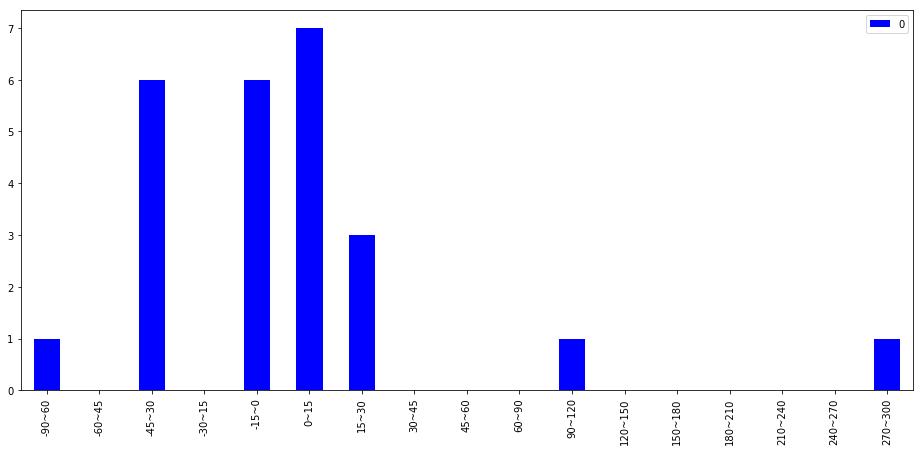

In [3]:
%pylab inline

import pandas as pd
import numpy as np

df = pd.read_excel('files/data.xlsx', sheetname="data")

df['Date'] = df['成交時間'].dt.year.astype(str)+df['成交時間'].dt.month.astype(str)
df['Lot'] = df['口數']
df['Balance'] = df['平倉損益']

df = df[['Date','Lot','Balance']]

obj = {}
obj['-90~60'] = df[(df['Balance']/df['Lot'] >= -4500) & (df['Balance']/df['Lot'] < -3000)]['Lot'].sum()
obj['-60~45'] = df[(df['Balance']/df['Lot'] >= -3000) & (df['Balance']/df['Lot'] < -2250)]['Lot'].sum()
obj['-45~30'] = df[(df['Balance']/df['Lot'] >= -2250) & (df['Balance']/df['Lot'] < -1500)]['Lot'].sum()
obj['-30~15'] = df[(df['Balance']/df['Lot'] >= -1500) & (df['Balance']/df['Lot'] < -750)]['Lot'].sum()
obj['-15~0'] = df[(df['Balance']/df['Lot'] >= -750) & (df['Balance']/df['Lot'] < 0)]['Lot'].sum()
obj['0~15'] = df[(df['Balance']/df['Lot'] >= 0) & (df['Balance']/df['Lot'] < 750)]['Lot'].sum()
obj['15~30'] = df[(df['Balance']/df['Lot'] >= 750) & (df['Balance']/df['Lot'] < 1500)]['Lot'].sum()
obj['30~45'] = df[(df['Balance']/df1['Lot'] >= 1500) & (df['Balance']/df['Lot'] < 2250)]['Lot'].sum()
obj['45~60'] = df[(df['Balance']/df1['Lot'] >= 2250) & (df['Balance']/df['Lot'] < 3000)]['Lot'].sum()
obj['60~90'] = df[(df['Balance']/df['Lot'] >= 3000) & (df['Balance']/df['Lot'] < 4500)]['Lot'].sum()
obj['90~120'] = df[(df['Balance']/df['Lot'] >= 4500) & (df['Balance']/df['Lot'] < 6000)]['Lot'].sum()
obj['120~150'] = df[(df['Balance']/df['Lot'] >= 6000) & (df['Balance']/df['Lot'] < 7500)]['Lot'].sum()
obj['150~180'] = df[(df['Balance']/df['Lot'] >= 7500) & (df['Balance']/df['Lot'] < 9000)]['Lot'].sum()
obj['180~210'] = df[(df['Balance']/df['Lot'] >= 9000) & (df['Balance']/df['Lot'] < 10500)]['Lot'].sum()
obj['210~240'] = df[(df['Balance']/df['Lot'] >= 10500) & (df['Balance']/df['Lot'] < 12000)]['Lot'].sum()
obj['240~270'] = df[(df['Balance']/df['Lot'] >= 12000) & (df['Balance']/df['Lot'] < 13500)]['Lot'].sum()
obj['270~300'] = df[(df['Balance']/df['Lot'] >= 13500) & (df['Balance']/df['Lot'] < 15000)]['Lot'].sum()


df = pd.DataFrame(obj, index=[0])
df = df[['-90~60','-60~45','-45~30','-30~15','-15~0','0~15','15~30','30~45','45~60',
         '60~90','90~120','120~150','150~180','180~210','210~240','240~270','270~300']]



df = pd.DataFrame(df.stack()[0])
df.plot(kind='bar',figsize=(16,7),color='b')

